##### 02 - Join JSON data with FashionLabels and start cleaning
This notebook loads the cleaned labels table, loads product events from JSON, and prepares them for joining and further cleaning.

In [1]:
# Find project root, import project modules, and load cleaned labels

from pathlib import Path
import sys
import pandas as pd

# Start from the current working directory and walk up until we find 'src'
cwd = Path.cwd()
project_root = None

for path in [cwd, *cwd.parents]:
    if (path / "src").is_dir():
        project_root = path
        break

if project_root is None:
    raise FileNotFoundError(
        "Could not find a folder containing 'src'. "
        "Please make sure you are working inside the PRODUCT-CLASSIFCATION project."
    )

SRC_DIR = project_root / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from config import PROCESSED_DATA_DIR
from preprocessing import normalize_text

# Load cleaned labels from the processed folder
labels_clean_path = PROCESSED_DATA_DIR / "labels_clean.parquet"
print("Loading labels from:", labels_clean_path)

labels_clean = pd.read_parquet(labels_clean_path)
labels_clean.head()

Loading labels from: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed/labels_clean.parquet


,product_name,relevant_code,label_raw,label,product_text_raw,product_text_norm
0,"molshine Hard Shell Sunglasses Case,Classic La...",0,0,0,"molshine Hard Shell Sunglasses Case,Classic La...",molshine hard shell sunglasses case classic la...
1,"AstroAI Car Jump Starter, 2000A 12V 8-in-1 Bat...",0,0,0,"AstroAI Car Jump Starter, 2000A 12V 8-in-1 Bat...",astroai car jump starter 2000a 12v 8 in 1 batt...
2,"molshine Hard Shell Sunglasses Case,Classic La...",0,0,0,"molshine Hard Shell Sunglasses Case,Classic La...",molshine hard shell sunglasses case classic la...
3,"N&ampT NIETING Burlap Christmas Tree Skirt, 30...",0,0,0,"N&ampT NIETING Burlap Christmas Tree Skirt, 30...",n ampt nieting burlap christmas tree skirt 30 ...
4,Vemiss Hard Shell Eyeglasses Case Linen Fabric...,0,0,0,Vemiss Hard Shell Eyeglasses Case Linen Fabric...,vemiss hard shell eyeglasses case linen fabric...


In [2]:
# Check how many part_00 JSON files we have per month folder

from collections import OrderedDict
from config import RAW_DATA_DIR

month_counts = OrderedDict()

for month_dir in sorted(RAW_DATA_DIR.glob("export_shopper=*")):
    count = len(list(month_dir.glob("*_part_00.json")))
    month_counts[month_dir.name] = count

print("Number of part_00 JSON files per month:")
for month, count in month_counts.items():
    print(f"{month}: {count}")

Number of part_00 JSON files per month:
export_shopper=AUG-24: 128
export_shopper=DEC-24: 128
export_shopper=FEB-25: 128
export_shopper=JAN-25: 128
export_shopper=JUL-24: 128
export_shopper=JUN-24: 128
export_shopper=MAY-24: 128
export_shopper=NOV-24: 128
export_shopper=OCT-24: 128
export_shopper=SEP-24: 128


In [3]:
# Load a sample JSON file and create raw + normalized product text columns

import pandas as pd
from config import RAW_DATA_DIR
from preprocessing import normalize_text

# Prefer AUG-24/0000_part_00.json as a representative sample if it exists,
# otherwise fall back to the first matching file we find
preferred_path = RAW_DATA_DIR / "export_shopper=AUG-24" / "0000_part_00.json"
if preferred_path.is_file():
    sample_json_path = preferred_path
else:
    all_first_parts = sorted(RAW_DATA_DIR.glob("export_shopper=*/0000_part_00.json"))
    if not all_first_parts:
        raise FileNotFoundError("No JSON files matching 'export_shopper=*/0000_part_00.json' found.")
    sample_json_path = all_first_parts[0]

print("Using sample JSON file:", sample_json_path)

# Read a chunk of the JSON file (not the whole thing) to inspect structure
json_iter = pd.read_json(
    sample_json_path,
    lines=True,
    chunksize=50000,
)

sample_json_df = next(json_iter)
print("Sample JSON columns:", sample_json_df.columns.tolist())

# Keep only the columns we care about for now, if they exist
cols_keep = ["event_id", "event_type", "start_time_local", "remove_amazon"]
cols_keep = [c for c in cols_keep if c in sample_json_df.columns]

sample_json_df = sample_json_df[cols_keep].copy()

# Add month information based on the folder name (e.g. export_shopper=AUG-24)
sample_json_df["month"] = sample_json_path.parent.name

# Create raw and normalized product text columns
sample_json_df["product_text_raw"] = sample_json_df["remove_amazon"]
sample_json_df["product_text_norm"] = sample_json_df["product_text_raw"].apply(normalize_text)

# Show a small sample of event_type + text to understand what we're dealing with
sample_json_df[["event_type", "product_text_raw", "product_text_norm"]].head(10)

Using sample JSON file: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/raw/export_shopper=AUG-24/0000_part_00.json
Sample JSON columns: ['event_id', 'panelist_id', 'event_name', 'event_type', 'start_time_local', 'end_time_local', 'search_term', 'page_view_id', 'product_id', 'remove_amazon', 'purchase_price', 'purchase_quantity', 'retailer_property_name', 'currency']


,event_type,product_text_raw,product_text_norm
0,Basket View,Lozeux Silver Plated 8mm Round Cut Created Rai...,lozeux silver plated 8mm round cut created rai...
1,Product Detail,PDP Afterglow™ Wave Enhanced Wireless Nintendo...,pdp afterglowtm wave enhanced wireless nintend...
2,Product Detail,Alma Gourmet White Chocolate Topping Sauce Imp...,alma gourmet white chocolate topping sauce imp...
3,Basket View,"GDME Women's Probiotics, 90 Tablets 90 Billion...",gdme women s probiotics 90 tablets 90 billion ...
4,Product Detail,"Fully Automatic Record Player, Bluetooth Belt ...",fully automatic record player bluetooth belt d...
5,Basket View,,
6,Basket View,"Heavy Duty Moving Bags Extra Large,Storage Bag...",heavy duty moving bags extra large storage bag...
7,Basket View,HOMEXCEL Dry Sweeping Cloths Pads Compatible w...,homexcel dry sweeping cloths pads compatible w...
8,Basket View,BemeyourBBs Toddler Baby Boy Summer Clothes Le...,bemeyourbbs toddler baby boy summer clothes le...
9,Product Detail,KastKing Kateel Polarized Sport Sunglasses for...,kastking kateel polarized sport sunglasses for...


In [4]:
# Quick EDA on event types and text availability in the sample JSON chunk

# How many rows per event_type in this sample?
event_counts = sample_json_df["event_type"].value_counts(dropna=False)
print("Event types in this sample:")
print(event_counts)
print()

# How many rows have missing or empty product_text_raw?
missing_text = sample_json_df["product_text_raw"].isna().sum()
empty_text = (sample_json_df["product_text_norm"] == "").sum()

print(f"Rows with NaN product_text_raw: {missing_text}")
print(f"Rows with empty normalized text: {empty_text}")

Event types in this sample:
event_type
Basket View              2889
Product Detail           1608
search                   1258
Checkout                   63
Purchase Confirmation      40
Name: count, dtype: int64

Rows with NaN product_text_raw: 0
Rows with empty normalized text: 1483


In [5]:
# Filter the sample JSON to rows with non-empty normalized product text.
# We keep event_type only for inspection; it will not be a model feature.

usable_mask = sample_json_df["product_text_norm"] != ""
usable_sample = sample_json_df[usable_mask].copy()

print("Total rows in sample_json_df:", len(sample_json_df))
print("Usable rows (non-empty product_text_norm):", len(usable_sample))

# Show a few example rows
usable_sample[["event_type", "product_text_raw", "product_text_norm"]].head(10)

Total rows in sample_json_df: 5858
Usable rows (non-empty product_text_norm): 4375


,event_type,product_text_raw,product_text_norm
0,Basket View,Lozeux Silver Plated 8mm Round Cut Created Rai...,lozeux silver plated 8mm round cut created rai...
1,Product Detail,PDP Afterglow™ Wave Enhanced Wireless Nintendo...,pdp afterglowtm wave enhanced wireless nintend...
2,Product Detail,Alma Gourmet White Chocolate Topping Sauce Imp...,alma gourmet white chocolate topping sauce imp...
3,Basket View,"GDME Women's Probiotics, 90 Tablets 90 Billion...",gdme women s probiotics 90 tablets 90 billion ...
4,Product Detail,"Fully Automatic Record Player, Bluetooth Belt ...",fully automatic record player bluetooth belt d...
6,Basket View,"Heavy Duty Moving Bags Extra Large,Storage Bag...",heavy duty moving bags extra large storage bag...
7,Basket View,HOMEXCEL Dry Sweeping Cloths Pads Compatible w...,homexcel dry sweeping cloths pads compatible w...
8,Basket View,BemeyourBBs Toddler Baby Boy Summer Clothes Le...,bemeyourbbs toddler baby boy summer clothes le...
9,Product Detail,KastKing Kateel Polarized Sport Sunglasses for...,kastking kateel polarized sport sunglasses for...
12,Product Detail,MODA - Cholesterol Deep Conditioning Hair Crea...,moda cholesterol deep conditioning hair cream ...


In [6]:
# Inspect some of the unusable rows where normalized text is empty

unusable_sample = sample_json_df[sample_json_df["product_text_norm"] == ""].copy()

print("Unusable rows sample (first 20):")
unusable_sample[["event_type", "product_text_raw", "product_text_norm"]].head(20)

Unusable rows sample (first 20):


,event_type,product_text_raw,product_text_norm
5,Basket View,,
10,Purchase Confirmation,,
11,search,,
15,search,,
16,search,,
21,search,,
22,search,,
28,search,,
36,search,,
37,search,,


In [7]:
# Use the reusable loader to process one JSON file into a clean product-text table

from pathlib import Path
from preprocessing import load_json_file_products

sample_products = load_json_file_products(Path(sample_json_path))

print("Rows with usable product text in this file:", len(sample_products))
sample_products.head(10)

Rows with usable product text in this file: 4375


,event_id,event_type,start_time_local,remove_amazon,month,product_text_raw,product_text_norm
0,0252da6da4ab596dc2628b908ce8a1b2,Basket View,2024-08-10 20:54:55.897,Lozeux Silver Plated 8mm Round Cut Created Rai...,export_shopper=AUG-24,Lozeux Silver Plated 8mm Round Cut Created Rai...,lozeux silver plated 8mm round cut created rai...
1,a1482efc380f0e522eb8592f8fd482db,Product Detail,2024-08-23 21:51:04.94,PDP Afterglow™ Wave Enhanced Wireless Nintendo...,export_shopper=AUG-24,PDP Afterglow™ Wave Enhanced Wireless Nintendo...,pdp afterglowtm wave enhanced wireless nintend...
2,2739b53a9266999ee01ec7d25e627cb2,Product Detail,2024-08-11 17:14:31.419,Alma Gourmet White Chocolate Topping Sauce Imp...,export_shopper=AUG-24,Alma Gourmet White Chocolate Topping Sauce Imp...,alma gourmet white chocolate topping sauce imp...
3,41189283254e761675e59f469753e78a,Basket View,2024-08-15 21:57:08.711,"GDME Women's Probiotics, 90 Tablets 90 Billion...",export_shopper=AUG-24,"GDME Women's Probiotics, 90 Tablets 90 Billion...",gdme women s probiotics 90 tablets 90 billion ...
4,6de70d25c19a14241799614e5f58a366,Product Detail,2024-08-24 18:52:26.788,"Fully Automatic Record Player, Bluetooth Belt ...",export_shopper=AUG-24,"Fully Automatic Record Player, Bluetooth Belt ...",fully automatic record player bluetooth belt d...
5,678d9e748c6d907ca919f626f67fe7c5,Basket View,2024-08-03 13:48:47.11,"Heavy Duty Moving Bags Extra Large,Storage Bag...",export_shopper=AUG-24,"Heavy Duty Moving Bags Extra Large,Storage Bag...",heavy duty moving bags extra large storage bag...
6,a5bb656abf27c18770f74fa9d7faea48,Basket View,2024-08-25 08:54:24.417,HOMEXCEL Dry Sweeping Cloths Pads Compatible w...,export_shopper=AUG-24,HOMEXCEL Dry Sweeping Cloths Pads Compatible w...,homexcel dry sweeping cloths pads compatible w...
7,49dc1aff9eecffec4561e2f12896a93f,Basket View,2024-08-23 15:58:29.876,BemeyourBBs Toddler Baby Boy Summer Clothes Le...,export_shopper=AUG-24,BemeyourBBs Toddler Baby Boy Summer Clothes Le...,bemeyourbbs toddler baby boy summer clothes le...
8,0a3ecbc111bc0925c099c6b0fef8bd99,Product Detail,2024-08-24 19:53:01.202,KastKing Kateel Polarized Sport Sunglasses for...,export_shopper=AUG-24,KastKing Kateel Polarized Sport Sunglasses for...,kastking kateel polarized sport sunglasses for...
9,610b9d48354e101d2330009383216e94,Product Detail,2024-08-10 13:27:05.661,MODA - Cholesterol Deep Conditioning Hair Crea...,export_shopper=AUG-24,MODA - Cholesterol Deep Conditioning Hair Crea...,moda cholesterol deep conditioning hair cream ...


In [8]:
# Build a small combined products table using 0000_part_00.json from each month.
# This is a "pilot" dataset to develop and test join + cleaning logic
# before scaling up to all 128 files per month.

from config import RAW_DATA_DIR
from preprocessing import load_json_file_products
from pathlib import Path

first_part_paths = sorted(RAW_DATA_DIR.glob("export_shopper=*/0000_part_00.json"))

all_products_small = []
for path in first_part_paths:
    df_month = load_json_file_products(Path(path))
    print(f"{path.parent.name} - rows with usable text: {len(df_month)}")
    all_products_small.append(df_month)

products_small = pd.concat(all_products_small, ignore_index=True)

print("\nCombined small products table shape:", products_small.shape)
print("Rows per month in this small combined table:")
print(products_small["month"].value_counts().sort_index())

export_shopper=AUG-24 - rows with usable text: 4375
export_shopper=DEC-24 - rows with usable text: 31635
export_shopper=FEB-25 - rows with usable text: 2130
export_shopper=JAN-25 - rows with usable text: 17679
export_shopper=JUL-24 - rows with usable text: 4404
export_shopper=JUN-24 - rows with usable text: 2986
export_shopper=MAY-24 - rows with usable text: 2439
export_shopper=NOV-24 - rows with usable text: 36761
export_shopper=OCT-24 - rows with usable text: 33427
export_shopper=SEP-24 - rows with usable text: 16936

Combined small products table shape: (152772, 7)
Rows per month in this small combined table:
month
export_shopper=AUG-24     4375
export_shopper=DEC-24    31635
export_shopper=FEB-25     2130
export_shopper=JAN-25    17679
export_shopper=JUL-24     4404
export_shopper=JUN-24     2986
export_shopper=MAY-24     2439
export_shopper=NOV-24    36761
export_shopper=OCT-24    33427
export_shopper=SEP-24    16936
Name: count, dtype: int64


In [9]:
# Check how much overlap we have between JSON product texts and label texts

prod_unique = products_small["product_text_norm"].nunique()
label_unique = labels_clean["product_text_norm"].nunique()

overlap = len(
    set(products_small["product_text_norm"]) & set(labels_clean["product_text_norm"])
)

print(f"Unique normalized texts in products_small: {prod_unique}")
print(f"Unique normalized texts in labels_clean : {label_unique}")
print(f"Overlap (shared normalized texts)       : {overlap}")

Unique normalized texts in products_small: 100331
Unique normalized texts in labels_clean : 548554
Overlap (shared normalized texts)       : 1249


In [10]:
# Join products_small with labels_clean on product_text_norm (inner join)

cols_labels_for_join = ["product_text_norm", "label", "label_raw"]

joined_small = products_small.merge(
    labels_clean[cols_labels_for_join],
    on="product_text_norm",
    how="inner",
)

print("products_small rows:", len(products_small))
print("joined_small rows  :", len(joined_small))
print("Unique product_text_norm in joined_small:", joined_small["product_text_norm"].nunique())

# Show a small sample of joined rows
joined_small[
    ["product_text_raw", "product_text_norm", "label_raw", "label", "month"]
].head(20)

products_small rows: 152772
joined_small rows  : 1893
Unique product_text_norm in joined_small: 1249


,product_text_raw,product_text_norm,label_raw,label,month
0,Gates K030267 Micro-V Serpentine Drive Belt,gates k030267 micro v serpentine drive belt,10,0,export_shopper=AUG-24
1,Nike Women's Running Low,nike women s running low,1,1,export_shopper=AUG-24
2,Nike Women's Running Low,nike women s running low,1,1,export_shopper=AUG-24
3,WHOUARE 4 Pack Biker Yoga Shorts with Pockets ...,whouare 4 pack biker yoga shorts with pockets ...,1,1,export_shopper=AUG-24
4,IDEGG No Show Socks Women 10 Pairs Low Cut Ant...,idegg no show socks women 10 pairs low cut ant...,1,1,export_shopper=AUG-24
5,"OROPY Industrial Pipe Clothing Rack 38.4"""", He...",oropy industrial pipe clothing rack 38 4 heavy...,10,0,export_shopper=AUG-24
6,ORAZIO 16Pcs Nose Rings For Women Surgical Ste...,orazio 16pcs nose rings for women surgical ste...,1,1,export_shopper=AUG-24
7,Loungefly Disney Alice In Wonderland A Very Me...,loungefly disney alice in wonderland a very me...,1,1,export_shopper=AUG-24
8,Under Armour Men's Charged Assert 9 Running Shoe,under armour men s charged assert 9 running shoe,1,1,export_shopper=AUG-24
9,Under Armour Men's Charged Assert 9 Running Shoe,under armour men s charged assert 9 running shoe,1,1,export_shopper=AUG-24


Total joined rows (events): 1893
Unique product_text_norm   : 1249
Rows belonging to duplicated product_text_norm values: 993

Number of product_text_norm values with conflicting labels (0 and 1): 0
Number of rows affected by conflicts: 0

Class balance in joined_small (0=non-fashion, 1=fashion):
label=0: 369 rows (19.49%)
label=1: 1524 rows (80.51%)


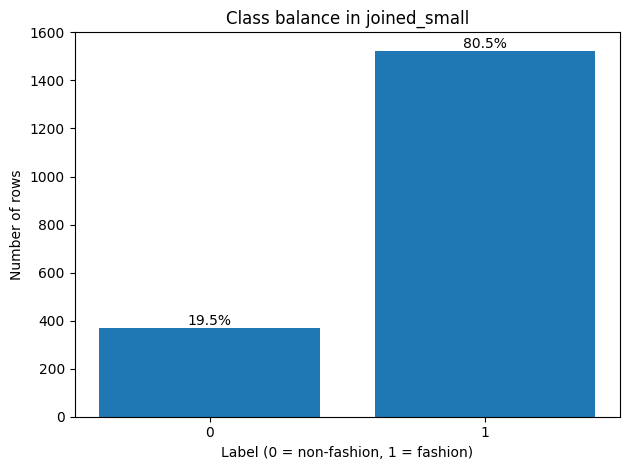


No conflicting labels found in this joined slice.


In [11]:
import matplotlib.pyplot as plt

# Basic counts
n_rows = len(joined_small)
n_unique = joined_small["product_text_norm"].nunique()
print(f"Total joined rows (events): {n_rows}")
print(f"Unique product_text_norm   : {n_unique}")

# How many rows are duplicates at the product_text_norm level?
dup_mask = joined_small["product_text_norm"].duplicated(keep=False)
n_dup_rows = dup_mask.sum()
print(f"Rows belonging to duplicated product_text_norm values: {n_dup_rows}")

# Detect conflicts: same normalized text with both labels 0 and 1
label_counts_by_text = joined_small.groupby("product_text_norm")["label"].nunique()
conflict_texts = label_counts_by_text[label_counts_by_text > 1].index

n_conflict_texts = len(conflict_texts)
n_conflict_rows = joined_small[joined_small["product_text_norm"].isin(conflict_texts)].shape[0]

print(f"\nNumber of product_text_norm values with conflicting labels (0 and 1): {n_conflict_texts}")
print(f"Number of rows affected by conflicts: {n_conflict_rows}")

# Class balance in the joined slice
cls_counts = joined_small["label"].value_counts().sort_index()
cls_pct = joined_small["label"].value_counts(normalize=True).sort_index() * 100

print("\nClass balance in joined_small (0=non-fashion, 1=fashion):")
for k in cls_counts.index:
    print(f"label={k}: {cls_counts[k]} rows ({cls_pct[k]:.2f}%)")

# Simple bar chart with percentages
labels_list = cls_counts.index.astype(str).tolist()
values = cls_counts.values
pct_values = [cls_pct[k] for k in cls_counts.index]
x_pos = range(len(labels_list))

plt.figure()
bars = plt.bar(x_pos, values)
plt.xticks(x_pos, labels_list)
plt.xlabel("Label (0 = non-fashion, 1 = fashion)")
plt.ylabel("Number of rows")
plt.title("Class balance in joined_small")

for x, height, pct in zip(x_pos, values, pct_values):
    plt.text(x, height, f"{pct:.1f}%", ha="center", va="bottom")

plt.grid(False)
plt.tight_layout()
plt.show()

# Show a few examples of any conflicts (if they exist)
if n_conflict_texts > 0:
    print("\nSample conflicting products:")
    display(
        joined_small[joined_small["product_text_norm"].isin(conflict_texts)]
        .sort_values("product_text_norm")
        .head(20)
    )
else:
    print("\nNo conflicting labels found in this joined slice.")

Conflicting product_text_norm values (should be 0 here): 0
Rows before dedup (no conflicts): 1893
Rows after dedup (unique products): 1249
Unique product_text_norm in product_level: 1249

Class balance at product level (0=non-fashion, 1=fashion):
label=0: 220 products (17.61%)
label=1: 1029 products (82.39%)


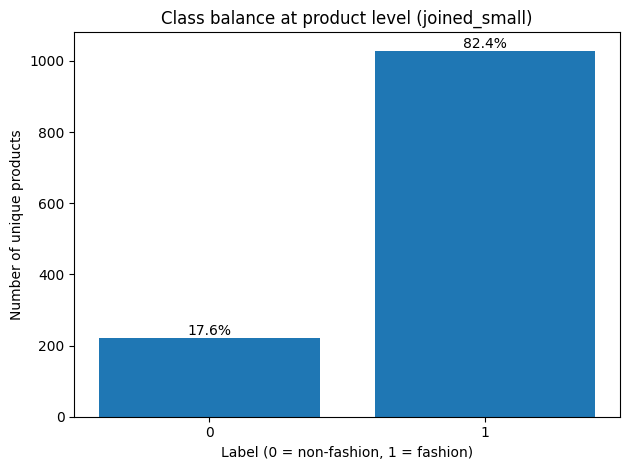

,product_text_raw,product_text_norm,label,month
719,"012 Jump Starter Battery Pack, 4000A Peak Car ...",012 jump starter battery pack 4000a peak car b...,0,export_shopper=JUN-24
1850,1 Pair Fashion Women Full Drill Hollow Ear Bon...,1 pair fashion women full drill hollow ear bon...,1,export_shopper=SEP-24
1160,10 Pieces Finger Claws Rings Full Finger Set R...,10 pieces finger claws rings full finger set r...,0,export_shopper=NOV-24
14,"100PCS Swivel Snap Hooks with Key Rings, Premi...",100pcs swivel snap hooks with key rings premiu...,0,export_shopper=AUG-24
1752,12 Box Crushed Glass Craft Glitter Fine for Re...,12 box crushed glass craft glitter fine for re...,0,export_shopper=SEP-24
195,12 Months Baby Girls Clothes 18 Months Girls 2...,12 months baby girls clothes 18 months girls 2...,1,export_shopper=DEC-24
1647,"135Pcs Sublimation Keychain Blanks Bulk,MDF Ke...",135pcs sublimation keychain blanks bulk mdf ke...,0,export_shopper=OCT-24
800,"16 Pack Curtain Rings with Clips, Window Clip ...",16 pack curtain rings with clips window clip r...,0,export_shopper=JUN-24
346,18 Pairs Stainless Steel Y2K Punk Hoop Dangle ...,18 pairs stainless steel y2k punk hoop dangle ...,1,export_shopper=FEB-25
524,18 Pieces Moon Witch Zipper Pouch Bag Tarot Ca...,18 pieces moon witch zipper pouch bag tarot ca...,0,export_shopper=JUL-24


In [13]:
# Turn joined_small (event-level) into a clean product-level table

# 1) Conflict resolution:
#    Drop any product_text_norm that has both labels 0 and 1.
#    In this slice there are none, but we write the logic for later.
label_counts_by_text = joined_small.groupby("product_text_norm")["label"].nunique()
conflict_texts = label_counts_by_text[label_counts_by_text > 1].index

print("Conflicting product_text_norm values (should be 0 here):", len(conflict_texts))

joined_no_conflicts = joined_small[
    ~joined_small["product_text_norm"].isin(conflict_texts)
].copy()

# 2) Deduplicate: keep one row per product_text_norm.
#    We keep the first occurrence; label is the same within each group after conflict removal.
before_dedup = len(joined_no_conflicts)

product_level = (
    joined_no_conflicts
    .sort_values(["product_text_norm", "start_time_local"])
    .drop_duplicates(subset=["product_text_norm"], keep="first")
    .copy()
)

after_dedup = len(product_level)

print(f"Rows before dedup (no conflicts): {before_dedup}")
print(f"Rows after dedup (unique products): {after_dedup}")
print(f"Unique product_text_norm in product_level: {product_level['product_text_norm'].nunique()}")

# 3) Class balance at product level
cls_counts_prod = product_level["label"].value_counts().sort_index()
cls_pct_prod = product_level["label"].value_counts(normalize=True).sort_index() * 100

print("\nClass balance at product level (0=non-fashion, 1=fashion):")
for k in cls_counts_prod.index:
    print(f"label={k}: {cls_counts_prod[k]} products ({cls_pct_prod[k]:.2f}%)")

# Simple bar chart for product-level balance
labels_list = cls_counts_prod.index.astype(str).tolist()
values = cls_counts_prod.values
pct_values = [cls_pct_prod[k] for k in cls_counts_prod.index]
x_pos = range(len(labels_list))

import matplotlib.pyplot as plt

plt.figure()
bars = plt.bar(x_pos, values)
plt.xticks(x_pos, labels_list)
plt.xlabel("Label (0 = non-fashion, 1 = fashion)")
plt.ylabel("Number of unique products")
plt.title("Class balance at product level (joined_small)")

for x, height, pct in zip(x_pos, values, pct_values):
    plt.text(x, height, f"{pct:.1f}%", ha="center", va="bottom")

plt.grid(False)
plt.tight_layout()
plt.show()

# Peek at a few product-level rows
product_level[["product_text_raw", "product_text_norm", "label", "month"]].head(10)

In [14]:
# Save the pilot product-level joined table to data/interim

from config import INTERIM_DATA_DIR

INTERIM_DATA_DIR.mkdir(parents=True, exist_ok=True)

pilot_path = INTERIM_DATA_DIR / "products_joined_small.parquet"
product_level.to_parquet(pilot_path, index=False)

print("Saved pilot joined product-level table to:", pilot_path)
print("Shape:", product_level.shape)

Saved pilot joined product-level table to: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/interim/products_joined_small.parquet
Shape: (1249, 9)


##### so in the steps above, we explored the data and understood and wrote code to preprocess the data as needed for a small dataset as that is the best practice when we have larger datasets and the following step i moved the code into proper functions in preprocessing.py to reuse it as a pipeline on the full dataset

In [15]:
# Test the reusable preprocessing functions on the same first-part-per-month files

from pathlib import Path
import importlib
import preprocessing  # import the module itself

# Reload to make sure we see the new functions
importlib.reload(preprocessing)

from preprocessing import (
    build_products_from_files,
    join_products_with_labels,
    to_product_level,
)

from config import RAW_DATA_DIR

# Rebuild products_small using the reusable function
first_part_paths = sorted(RAW_DATA_DIR.glob("export_shopper=*/0000_part_00.json"))

products_small_v2 = build_products_from_files(first_part_paths)
joined_small_v2 = join_products_with_labels(products_small_v2, labels_clean)
product_level_v2 = to_product_level(joined_small_v2)

print("Original products_small shape :", products_small.shape)
print("New products_small_v2 shape   :", products_small_v2.shape)
print("Original joined_small shape   :", joined_small.shape)
print("New joined_small_v2 shape     :", joined_small_v2.shape)
print("Original product_level shape  :", product_level.shape)
print("New product_level_v2 shape    :", product_level_v2.shape)

product_level_v2.head(10)

Original products_small shape : (152772, 7)
New products_small_v2 shape   : (152772, 7)
Original joined_small shape   : (1893, 9)
New joined_small_v2 shape     : (1893, 9)
Original product_level shape  : (1249, 9)
New product_level_v2 shape    : (1249, 9)


,event_id,event_type,start_time_local,remove_amazon,month,product_text_raw,product_text_norm,label_raw,label
719,58f144d19ec6229a4a2a4ed4c4eeaba5,Product Detail,2024-06-10 07:32:37.247,"012 Jump Starter Battery Pack, 4000A Peak Car ...",export_shopper=JUN-24,"012 Jump Starter Battery Pack, 4000A Peak Car ...",012 jump starter battery pack 4000a peak car b...,10,0
1850,ca2769684eecf31a2bc9a5bae2ac082f,Basket View,2024-09-01 18:18:34.846,1 Pair Fashion Women Full Drill Hollow Ear Bon...,export_shopper=SEP-24,1 Pair Fashion Women Full Drill Hollow Ear Bon...,1 pair fashion women full drill hollow ear bon...,1,1
1160,c7fa1a2bd5e860653b2977efbcd93eac,Basket View,2024-11-10 15:50:02.904,10 Pieces Finger Claws Rings Full Finger Set R...,export_shopper=NOV-24,10 Pieces Finger Claws Rings Full Finger Set R...,10 pieces finger claws rings full finger set r...,10,0
14,50154f52de4f90505e4fdeb7b6582bae,Basket View,2024-08-24 20:07:20.74,"100PCS Swivel Snap Hooks with Key Rings, Premi...",export_shopper=AUG-24,"100PCS Swivel Snap Hooks with Key Rings, Premi...",100pcs swivel snap hooks with key rings premiu...,0,0
1752,dedfbc0aadebc886e8e8a1f7c858d413,Basket View,2024-09-29 14:17:10.318,12 Box Crushed Glass Craft Glitter Fine for Re...,export_shopper=SEP-24,12 Box Crushed Glass Craft Glitter Fine for Re...,12 box crushed glass craft glitter fine for re...,0,0
195,b1456051f8d85d289441b1deeb59b3d3,Product List,2024-12-15 15:29:02.127,12 Months Baby Girls Clothes 18 Months Girls 2...,export_shopper=DEC-24,12 Months Baby Girls Clothes 18 Months Girls 2...,12 months baby girls clothes 18 months girls 2...,1,1
1647,326cb8510fcde3db152f24301ef84756,Basket View,2024-10-17 00:19:36.986,"135Pcs Sublimation Keychain Blanks Bulk,MDF Ke...",export_shopper=OCT-24,"135Pcs Sublimation Keychain Blanks Bulk,MDF Ke...",135pcs sublimation keychain blanks bulk mdf ke...,10,0
800,ea9fce7557683b74a49936e23ab4c596,Basket View,2024-06-01 20:19:00.097,"16 Pack Curtain Rings with Clips, Window Clip ...",export_shopper=JUN-24,"16 Pack Curtain Rings with Clips, Window Clip ...",16 pack curtain rings with clips window clip r...,10,0
346,e934054ed3334c75520c58bd0b270116,Product Detail,2025-02-01 22:39:09.489,18 Pairs Stainless Steel Y2K Punk Hoop Dangle ...,export_shopper=FEB-25,18 Pairs Stainless Steel Y2K Punk Hoop Dangle ...,18 pairs stainless steel y2k punk hoop dangle ...,1,1
524,cd6e129af80dc1cf2673d3521f1f06d1,Basket View,2024-07-03 10:07:14.639,18 Pieces Moon Witch Zipper Pouch Bag Tarot Ca...,export_shopper=JUL-24,18 Pieces Moon Witch Zipper Pouch Bag Tarot Ca...,18 pieces moon witch zipper pouch bag tarot ca...,10,0


##### I first want to check this on one month in the cell below to see if my laptop can handle it

In [16]:
# Build a full product-level joined table for one month (AUG-24) using all its JSON files

from config import RAW_DATA_DIR
from preprocessing import build_products_from_files, join_products_with_labels, to_product_level
from pathlib import Path

# 1) Collect all JSON files for AUG-24
month_name = "export_shopper=AUG-24"
month_dir = RAW_DATA_DIR / month_name
month_files = sorted(month_dir.glob("*.json"))

print(f"Month: {month_name}")
print(f"Number of JSON files for this month: {len(month_files)}")

# 2) Build event-level products for this month
products_aug = build_products_from_files(month_files)
print("Event-level products_aug shape:", products_aug.shape)

# 3) Join with labels
joined_aug = join_products_with_labels(products_aug, labels_clean)
print("Joined event-level table (joined_aug) shape:", joined_aug.shape)

# 4) Convert to product-level (conflict resolution + dedup)
product_level_aug = to_product_level(joined_aug)
print("Product-level table (product_level_aug) shape:", product_level_aug.shape)

# 5) Class balance at product level for this month
cls_counts_aug = product_level_aug["label"].value_counts().sort_index()
cls_pct_aug = product_level_aug["label"].value_counts(normalize=True).sort_index() * 100

print("\nClass balance at product level for AUG-24 (0=non-fashion, 1=fashion):")
for k in cls_counts_aug.index:
    print(f"label={k}: {cls_counts_aug[k]} products ({cls_pct_aug[k]:.2f}%)")

product_level_aug.head(10)

Month: export_shopper=AUG-24
Number of JSON files for this month: 128
Event-level products_aug shape: (572074, 7)
Joined event-level table (joined_aug) shape: (8039, 9)
Product-level table (product_level_aug) shape: (1621, 9)

Class balance at product level for AUG-24 (0=non-fashion, 1=fashion):
label=0: 301 products (18.57%)
label=1: 1320 products (81.43%)


,event_id,event_type,start_time_local,remove_amazon,month,product_text_raw,product_text_norm,label_raw,label
835,3ac673ccc92f457cfa46657b30322aab,Product Detail,2024-08-24 14:44:00.378,"1.5 Gram x 50 Vial Convenient Super Glue, Wegl...",export_shopper=AUG-24,"1.5 Gram x 50 Vial Convenient Super Glue, Wegl...",1 5 gram x 50 vial convenient super glue wegla...,10,0
7495,00e9cfe2727b2e3136f61d806d3378c8,Product Detail,2024-08-24 07:26:18.242,10 Sets 14-16 Inch Baby Doll Clothes Dress Out...,export_shopper=AUG-24,10 Sets 14-16 Inch Baby Doll Clothes Dress Out...,10 sets 14 16 inch baby doll clothes dress out...,10,0
7649,4e8021c4d566e760de9582df1c404212,Basket View,2024-08-24 16:43:07.41,"100PCS Swivel Snap Hooks with Key Rings, Premi...",export_shopper=AUG-24,"100PCS Swivel Snap Hooks with Key Rings, Premi...",100pcs swivel snap hooks with key rings premiu...,0,0
2061,91211b525bd96dc26e6a11bc37b985ce,Product Detail,2024-08-04 20:00:45.796,100S JEWELRY Tungsten Rings For Men Wedding Ba...,export_shopper=AUG-24,100S JEWELRY Tungsten Rings For Men Wedding Ba...,100s jewelry tungsten rings for men wedding ba...,1,1
7164,e2de3919b4898aa66f7131c25309e425,Product Detail,2024-08-16 22:09:10.362,104 Pieces Self Adhesive Chenille Letter Patch...,export_shopper=AUG-24,104 Pieces Self Adhesive Chenille Letter Patch...,104 pieces self adhesive chenille letter patch...,0,0
2013,c18fa71c1124ead8a23ad98dea0d9b0a,Basket View,2024-08-25 01:49:07.556,12 Pairs 18K Gold Plated Surgical Stainless St...,export_shopper=AUG-24,12 Pairs 18K Gold Plated Surgical Stainless St...,12 pairs 18k gold plated surgical stainless st...,1,1
2488,80f9e88c14c06a7072a88f3507183168,Product Detail,2024-08-10 13:49:16.612,16 Pack Sole Protector for High Heel Shoes Red...,export_shopper=AUG-24,16 Pack Sole Protector for High Heel Shoes Red...,16 pack sole protector for high heel shoes red...,10,0
890,e866c1bb3faaa231b4552f29fdd072e7,Basket View,2024-08-17 19:52:31.444,16 Pairs Dangle Earrings For Women Trendy Diam...,export_shopper=AUG-24,16 Pairs Dangle Earrings For Women Trendy Diam...,16 pairs dangle earrings for women trendy diam...,1,1
5524,cf27ab1ccf99584c38d9ca05c3b45015,Product Detail,2024-08-24 09:53:45.571,16G 8mm Surgical Steel Nose Septum Horseshoe H...,export_shopper=AUG-24,16G 8mm Surgical Steel Nose Septum Horseshoe H...,16g 8mm surgical steel nose septum horseshoe h...,0,0
292,3083874cc5bccae02365571448bad98c,Product Detail,2024-08-27 19:22:33.485,18K White Gold Plated Round Square Cubic Zirco...,export_shopper=AUG-24,18K White Gold Plated Round Square Cubic Zirco...,18k white gold plated round square cubic zirco...,1,1


##### Run all the preceprocessing on the complete datset below

In [17]:
# Build product-level joined tables for ALL months, month by month,
# and save each to data/interim.

from config import RAW_DATA_DIR, INTERIM_DATA_DIR
from preprocessing import build_products_from_files, join_products_with_labels, to_product_level
from pathlib import Path

INTERIM_DATA_DIR.mkdir(parents=True, exist_ok=True)

summary_rows = []

month_dirs = sorted(RAW_DATA_DIR.glob("export_shopper=*"))

for month_dir in month_dirs:
    month_name = month_dir.name
    month_files = sorted(month_dir.glob("*.json"))
    print(f"\n=== Processing {month_name} ===")
    print(f"Number of JSON files: {len(month_files)}")

    if not month_files:
        print("No files found, skipping.")
        continue

    # 1) Event-level products for this month
    products_month = build_products_from_files(month_files)
    print("Event-level products shape:", products_month.shape)

    # 2) Join with labels
    joined_month = join_products_with_labels(products_month, labels_clean)
    print("Joined event-level shape  :", joined_month.shape)

    # 3) Product-level table (conflict resolution + dedup)
    product_level_month = to_product_level(joined_month)
    print("Product-level shape       :", product_level_month.shape)

    # 4) Class balance for this month (product-level)
    cls_counts = product_level_month["label"].value_counts().sort_index()
    cls_pct = product_level_month["label"].value_counts(normalize=True).sort_index() * 100

    n0 = int(cls_counts.get(0, 0))
    n1 = int(cls_counts.get(1, 0))
    p0 = float(cls_pct.get(0, 0.0))
    p1 = float(cls_pct.get(1, 0.0))

    print(f"label=0: {n0} products ({p0:.2f}%)")
    print(f"label=1: {n1} products ({p1:.2f}%)")

    # 5) Save this month’s product-level table
    out_path = INTERIM_DATA_DIR / f"products_joined_{month_name}.parquet"
    product_level_month.to_parquet(out_path, index=False)
    print("Saved to:", out_path)

    summary_rows.append(
        {
            "month": month_name,
            "event_rows": len(products_month),
            "joined_rows": len(joined_month),
            "product_rows": len(product_level_month),
            "products_label_0": n0,
            "products_label_1": n1,
            "pct_label_0": p0,
            "pct_label_1": p1,
        }
    )

# Build a small summary table across months
summary_df = pd.DataFrame(summary_rows).sort_values("month")
summary_df


=== Processing export_shopper=AUG-24 ===
Number of JSON files: 128
Event-level products shape: (572074, 7)
Joined event-level shape  : (8039, 9)
Product-level shape       : (1621, 9)
label=0: 301 products (18.57%)
label=1: 1320 products (81.43%)
Saved to: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/interim/products_joined_export_shopper=AUG-24.parquet

=== Processing export_shopper=DEC-24 ===
Number of JSON files: 128
Event-level products shape: (4098760, 7)
Joined event-level shape  : (35729, 9)
Product-level shape       : (3074, 9)
label=0: 418 products (13.60%)
label=1: 2656 products (86.40%)
Saved to: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/interim/products_joined_export_shopper=DEC-24.parquet

=== Processing export_shopper=FEB-25 ===
Number of JSON files: 128
Event-level products shape: (284116, 7)
Joined event-level shape  : (2657, 9)
Product-level shape       : (561, 9)
label=0: 67 product

,month,event_rows,joined_rows,product_rows,products_label_0,products_label_1,pct_label_0,pct_label_1
0,export_shopper=AUG-24,572074,8039,1621,301,1320,18.568785,81.431215
1,export_shopper=DEC-24,4098760,35729,3074,418,2656,13.597918,86.402082
2,export_shopper=FEB-25,284116,2657,561,67,494,11.942959,88.057041
3,export_shopper=JAN-25,2281936,18712,2437,339,2098,13.910546,86.089454
4,export_shopper=JUL-24,570297,12920,2204,363,1841,16.470054,83.529946
5,export_shopper=JUN-24,380851,26536,7568,1163,6405,15.367336,84.632664
6,export_shopper=MAY-24,318074,23649,6263,898,5365,14.338177,85.661823
7,export_shopper=NOV-24,4742333,54391,3448,453,2995,13.138051,86.861949
8,export_shopper=OCT-24,4309497,47883,3619,510,3109,14.092291,85.907709
9,export_shopper=SEP-24,2208212,22934,2008,280,1728,13.944223,86.055777
